In [78]:
import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB0
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os

In [79]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
NUM_CLASSES = 2
EPOCHS = 40

In [36]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/dfuaug/DFU(Aug)/',
    labels='inferred',
#     label_mode='int',
    batch_size=32,
    image_size=(240, 240),
    validation_split=0.2,
    subset='training',
    seed=0)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/dfuaug/DFU(Aug)/',
    labels='inferred',
#     label_mode='int',
    batch_size=32,
    image_size=(240, 240),
    validation_split=0.2,
    subset='validation',
    seed=0)

Found 5272 files belonging to 2 classes.
Using 4218 files for training.
Found 5272 files belonging to 2 classes.
Using 1054 files for validation.


In [37]:
train_ds = train_ds.shuffle(buffer_size=2500, seed=0)
validation_ds = validation_ds.shuffle(buffer_size=500, seed=0)

In [14]:
class_names = train_ds.class_names
class_names

AttributeError: '_ShuffleDataset' object has no attribute 'class_names'

In [29]:
size = (IMAGE_HEIGHT, IMAGE_WIDTH)
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
validation_ds = validation_ds.map(lambda image, label: (tf.image.resize(image, size), label))

In [38]:
for images, labels in train_ds.take(1):  # 'take(1)' gets the first batch
    print("Images:", images)
    print("Labels:", labels)


Images: tf.Tensor(
[[[[232.        215.        187.       ]
   [232.9       215.9       187.9      ]
   [234.66667   215.16667   188.       ]
   ...
   [209.66666   177.66666   136.66666  ]
   [207.9       175.9       134.9      ]
   [207.        175.        134.       ]]

  [[228.4       211.4       183.4      ]
   [229.29999   212.29999   184.29999  ]
   [233.31667   213.81667   186.65     ]
   ...
   [202.01666   170.01666   129.01666  ]
   [202.59      170.59      129.59     ]
   [202.5       170.5       129.5      ]]

  [[225.5       208.5       178.83333  ]
   [227.9       210.9       181.23334  ]
   [232.33334   213.52779   184.       ]
   ...
   [212.41669   179.58334   138.58334  ]
   [215.50002   182.66667   141.66667  ]
   [217.        184.16667   143.16667  ]]

  ...

  [[147.16667    94.16667    78.16667  ]
   [145.36667    92.36667    76.36667  ]
   [144.19444    91.19444    75.19444  ]
   ...
   [ 55.305565   33.305565   22.305565 ]
   [ 56.83333    34.83333    23.833328

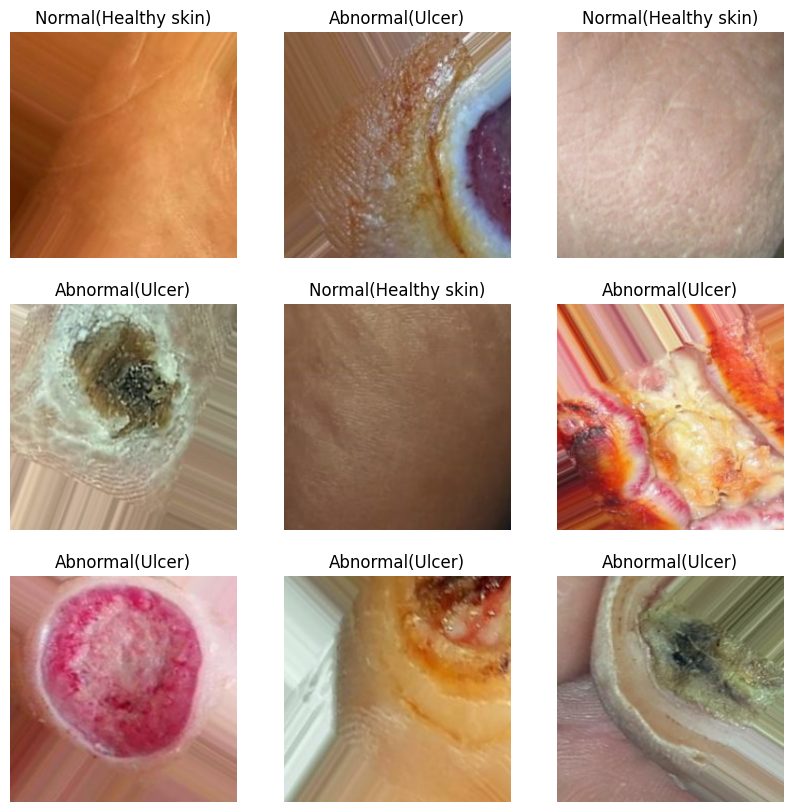

In [39]:
# Visualize the training dataset
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# img_augmentation_layers = [
#     layers.RandomRotation(factor=0.15),
#     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#     layers.RandomFlip(),
#     layers.RandomContrast(factor=0.1),
# ]


# def img_augmentation(images):
#     for layer in img_augmentation_layers:
#         images = layer(images)
#     return images

In [40]:
def input_preprocess_train(image, label):
#     image = img_augmentation(image)
#     label = tf.cast(label, tf.int32)  # Convert label to integer type
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def input_preprocess_test(image, label):
#     label = tf.cast(label, tf.int32)  # Convert label to integer type
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

validation_ds = validation_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
# validation_ds = validation_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [41]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.01, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [42]:
model = EfficientNetB1(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(240, 240, 3),
)
model.compile(optimizer="sgd", loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy',
                                                                                keras.metrics.Precision(), 
                                                                                keras.metrics.Recall(),
                                                                                keras.metrics.F1Score()])

# model.summary()

epochs = 100  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks = [lr_callback, 
                                                                                      stop_callback],
verbose=1)

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 172s 691ms/step - accuracy: 0.7037 - f1_score: 0.6975 - loss: 0.8734 - precision_4: 0.7037 - recall_4: 0.7037 - val_accuracy: 0.5171 - val_f1_score: 0.3408 - val_loss: 0.8420 - val_precision_4: 0.5171 - val_recall_4: 0.5171 - learning_rate: 0.0100
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.8092 - f1_score: 0.8077 - loss: 0.5462 - precision_4: 0.8092 - recall_4: 0.8092 - val_accuracy: 0.5171 - val_f1_score: 0.3408 - val_loss: 0.9635 - val_precision_4: 0.5171 - val_recall_4: 0.5171 - learning_rate: 0.0100
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.8415 - f1_score: 0.8412 - loss: 0.4496 - precision_4: 0.8415 - recall_4: 0.8415 - val_accuracy: 0.7315 - val_f1_score: 0.7106 - val_loss: 0.6972 - val_precision_4: 0.7315 - val_recall_4: 0.7315 - learning_rate: 0.0100
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.8677 - f1_score: 0.8673 - loss: 0.4289 - precision_4: 0.8677 - re

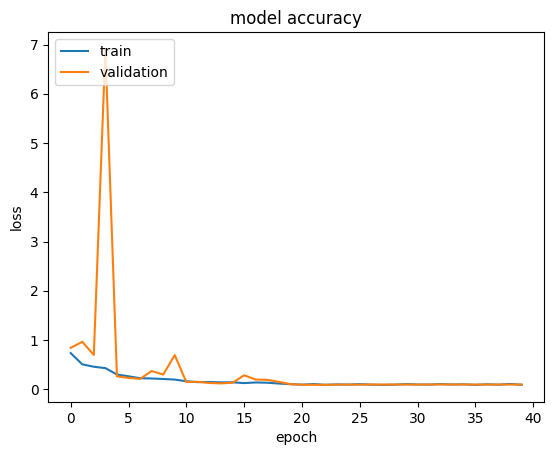

In [45]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model accuracy")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

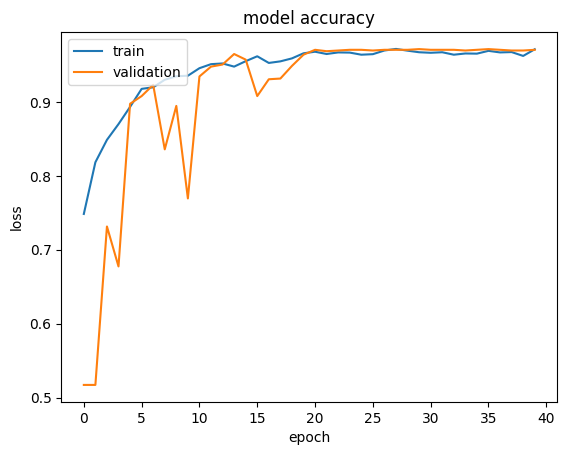

In [44]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

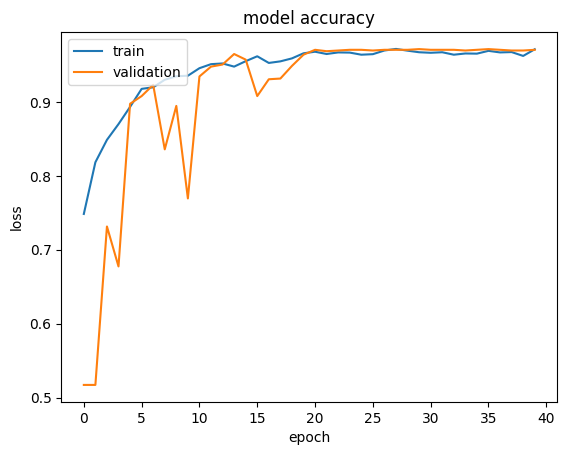

In [47]:
def plot_hist(hist):
    plt.plot(hist.history["precision_4"])
    plt.plot(hist.history["val_precision_4"])
    plt.title("model accuracy")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

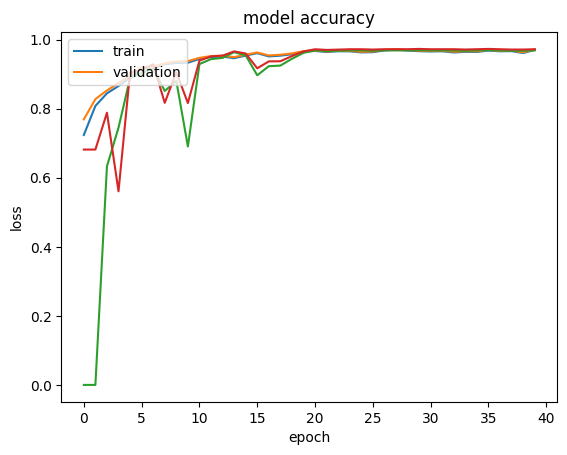

In [48]:
def plot_hist(hist):
    plt.plot(hist.history["f1_score"])
    plt.plot(hist.history["val_f1_score"])
    plt.title("model accuracy")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
model.predict('/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/10.jpg')

In [77]:
def preprocess_image(image_path, target_size=(240, 240)):
    # Load the image
    image = Image.open(image_path)
    
    # Resize the image
    image = image.resize(target_size)
    
    # Convert image to numpy array
    image_array = np.array(image)
    
    # Expand dimensions to match model input shape
    image_array = np.expand_dims(image_array, axis=0)
    
    return image_array

# Path to the image
image_path = '/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patches/Normal(Healthy skin)/110.jpg'

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Predict using the model
predictions = model.predict(preprocessed_image)
print(np.argmax(predictions))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1


In [70]:

def preprocess_image(image_path, target_size=(240, 240)):
    # Load the image
    image = Image.open(image_path)
    
    # Resize the image
    image = image.resize(target_size)
    
    # Convert image to numpy array
    image_array = np.array(image)
    
    # Expand dimensions to match model input shape
    image_array = np.expand_dims(image_array, axis=0)
    
    return image_array

# Path to the folder containing images
folder_path = '/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet'

# List to store predictions
predictions_list = []
i = 0
# Iterate over all files in the directory
for file_name in os.listdir(folder_path):
    i +=1
    file_path = os.path.join(folder_path, file_name)
    
    # Ensure that the file is an image (you can add more checks if needed)
    if file_path.lower().endswith(('.jpg', '.jpeg')):
        # Preprocess the image
        print(file_path)
        preprocessed_image = preprocess_image(file_path)
        
        # Predict using the model
        predictions = model.predict(preprocessed_image)
        
        # Store the result (assuming class index with highest probability)
        predictions_list.append(np.argmax(predictions))
        
        if i ==20:
            break
# Convert predictions to a numpy array (optional)
predictions_array = np.array(predictions_list)

print(predictions_array)

/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/b4b2e1341a7bf627a58f6ac32212ed93.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/20.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/foot-ulcer-217x300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/images (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/images (4).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/feat_footulcer_cellul_1110_127752_127753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
/kaggle/input/diabetic-foot-ulcer-dfu/DFU/TestSet/pt08cover4_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
/kaggle/input/diabetic-foot-ulcer-

In [56]:
print("Model input shape:", model.input_shape)


Model input shape: (None, 240, 240, 3)


In [76]:
model.save('DFU_v1_sgd_BCE_100.keras')

In [80]:
!pip3 freeze > requirements.txt

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [59]:
a = np.array([2])


In [75]:
print(max(hist.history['accuracy']))
print(max(hist.history['val_accuracy']))

0.9717875719070435
0.9715369939804077
